<a href="https://colab.research.google.com/github/clarakl/UoA-GEOG761/blob/main/761_Lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 5: Introducing GeoAI
In the words of the developers themselves:
"GeoAI is a comprehensive Python package designed to bridge artificial intelligence (AI) and geospatial data analysis, providing researchers and practitioners with intuitive tools for applying machine learning techniques to geographic data. The package offers a unified framework for processing satellite imagery, aerial photographs, and vector data using state-of-the-art deep learning models. GeoAI integrates popular AI frameworks including PyTorch, Transformers, PyTorch Segmentation Models, and specialized geospatial libraries like torchange, enabling users to perform complex geospatial analyses with minimal code."
- [GeoAI 2025](https://opengeoai.org/)


The aim of the this lab is take the knowldege of fundamental mechanics in both satellite data and AI that you have this far gained- and apply them via the bridge that GeoAI provides.

This lab is a modified version of the following tutorial:
- [GeoAI Workshop 2025](https://www.youtube.com/watch?v=jdK-cleFUkc&ab_channel=OpenGeospatialSolutions)


# Task 1: mapping surface water with S2
We start by installing the required package and setting CoLab to run on a GPU (until now, we have been running all our code on a CPU).

In [ ]:
# Install
!pip install "geoai-py" --quiet

In [ ]:
# Import
import geoai

To use GPU, please click the "Runtime" menu and select "Change runtime type". Then select "T4 GPU" from the dropdown menu. GPU acceleration is highly recommended for training deep learning models, as it can reduce training time from hours to minutes.

If you are running this lab on your own laptop, follow the installation instructions linked below in order to ensure that GPU and subsequent CUDA usage is connected up correctly [people using Colab, no need to do so]:
- https://opengeoai.org/installation/

Next, we will get the training data. In this case, GeoAI have linked to the work of Xin Luo who has prepped the [Earth Surface Water](https://zenodo.org/records/5205674#.Y4iEFezP1hE) Dataset from Zenodo, which contains Sentinel-2 imagery with 6 spectral bands and corresponding water masks. This is a high quality dataset that is a good example of 'ready to go' data.



In [ ]:
# Access the data
url = "https://huggingface.co/datasets/giswqs/geospatial/resolve/main/dset-s2.zip"
data_dir = geoai.download_file(url, output_path="dset-s2.zip")

Extracted to: dset-s2


As ever, we will use the training images and masks to train our model, then evaluate performance on the completely independent validation set.

In [ ]:
images_dir = f"{data_dir}/dset-s2/tra_scene"
masks_dir = f"{data_dir}/dset-s2/tra_truth"
tiles_dir = f"{data_dir}/dset-s2/tiles"

We'll create smaller training tiles from the large GeoTIFF images. Note that we have multiple Sentinel-2 scenes in the training and validation sets, we will use the [GeoAI] export_geotiff_tiles_batch function to export tiles from each scene.

In [ ]:
result = geoai.export_geotiff_tiles_batch(
    images_folder=images_dir,
    masks_folder=masks_dir,
    output_folder=tiles_dir,
    tile_size=512,
    stride=128,
    quiet=True,
)

**Q1**: With a tile_size of 512, what is the area in m2 covered by a single tile?

Now we'll train a semantic segmentation model specifically for **6-channel** Sentinel-2 imagery. The key difference from our previous model is the input channel configuration.

Important parameters to note:
- num_channels=6: Accommodate the 6 Sentinel-2 spectral bands (Blue, Green, Red, NIR, SWIR1, SWIR2)
- Architecture is a U-Net + ResNet34: these are proven effective for multispectral imagery


Let's train the model using the Sentinel-2 tiles:

**Q2**: Explain why using U-Net and ResNet34 together is a good choice when working with multi-spectral imagery.

In [ ]:
geoai.train_segmentation_model(
    images_dir=f"{tiles_dir}/images",
    labels_dir=f"{tiles_dir}/masks",
    output_dir=f"{tiles_dir}/unet_models",
    architecture="unet",
    encoder_name="resnet34",
    encoder_weights="imagenet",
    num_channels=6,
    num_classes=2,  # background and water
    batch_size=32,
    num_epochs=3,  # training for 3 epochs to save time, in practice you should train for more epochs
    learning_rate=0.001,
    val_split=0.2,
    verbose=True,
)

**Q3**: What is the learning_rate and what is the likely effect that reducing it will have on your model?

This model took me 7 to 10 minutes to run on the GPU. If it is taking you more than that, check that you are not still stuck using a CPU (it will take a LOT longer if on a CPU).

With one line of code, we can now take a look at the model performance:

In [ ]:
# Performance statistics
geoai.plot_performance_metrics(
    history_path=f"{tiles_dir}/unet_models/training_history.pth",
    figsize=(15, 5),
    verbose=True,
)

**Q4**: Increase the number of training epochs to 10 (this will take some time, so maybe come back to this question later if need be). Present the resulting graphs of performance metrics in a figure and interpret the results for a technical audience (describe the training that has occured and make reccomendations for future training/use of the model). As always, figures should be of publication quality.

In addition to these performance statistics, we can run [inference](https://www.cloudflare.com/learning/ai/inference-vs-training/) on the validation set to evaluate the model's performance. We will use the semantic_segmentation_batch function to process all the validation images at once.

In [ ]:
images_dir = f"{data_dir}/dset-s2/val_scene"
masks_dir = f"{data_dir}/dset-s2/val_truth"
predictions_dir = f"{data_dir}/dset-s2/predictions"
model_path = f"{tiles_dir}/unet_models/best_model.pth"

In [ ]:
geoai.semantic_segmentation_batch(
    input_dir=images_dir,
    output_dir=predictions_dir,
    model_path=model_path,
    architecture="unet",
    encoder_name="resnet34",
    num_channels=6,
    num_classes=2,
    window_size=512,
    overlap=256,
    batch_size=32,
    quiet=True,
)

In [ ]:
geoai.train_segmentation_model(
    images_dir=f"{tiles_dir}/images",
    labels_dir=f"{tiles_dir}/masks",
    output_dir=f"{tiles_dir}/unet_models",
    architecture="unet",
    encoder_name="resnet34",
    encoder_weights="imagenet",
    num_channels=6,
    num_classes=2,  # background and water
    batch_size=32,
    num_epochs=10,
    learning_rate=0.001,
    val_split=0.2,
    verbose=True,
)

In [ ]:
# Performance statistics
geoai.plot_performance_metrics(
    history_path=f"{tiles_dir}/unet_models/training_history.pth",
    figsize=(15, 5),
    verbose=True,
)

And then visualize the results of this!

In [ ]:
# Visualize inference outcomes
image_id = "S2A_L2A_20190318_N0211_R061"  # Change to other image id, e.g., S2B_L2A_20190620_N0212_R047
test_image_path = f"{data_dir}/dset-s2/val_scene/{image_id}_6Bands_S2.tif"
ground_truth_path = f"{data_dir}/dset-s2/val_truth/{image_id}_S2_Truth.tif"
prediction_path = f"{data_dir}/dset-s2/predictions/{image_id}_6Bands_S2_mask.tif"
save_path = f"{data_dir}/dset-s2/{image_id}_6Bands_S2_comparison.png"

fig = geoai.plot_prediction_comparison(
    original_image=test_image_path,
    prediction_image=prediction_path,
    ground_truth_image=ground_truth_path,
    titles=["Original", "Prediction", "Ground Truth"],
    figsize=(15, 5),
    save_path=save_path,
    show_plot=True,
    indexes=[5, 4, 3],
    divider=5000,
)

In [ ]:
# Creating a publication-ready figure from the performance results, but we needed to use a manually forced "non-show" for plots of all kinds
# Because GeoAI does not allow that internally. Never forget to reintroduce the right for plots to show!

import matplotlib.pyplot as plt

# Save the original plt.show() function
original_show = plt.show

# Temporarily overwrite plt.show with a dummy function that does nothing
plt.show = lambda: None

# Run the library function. It will try to show the plot,
# but our dummy function will run instead, preventing it.
geoai.plot_performance_metrics(
    history_path=f"{tiles_dir}/unet_models/training_history.pth",
    figsize=(15, 5),
    verbose=True,
)

# IMPORTANT: Restore the original plt.show() function
plt.show = original_show

# Now, the plot exists but hasn't been shown. We can grab it and modify it.
fig = plt.gcf()

fig.suptitle(
    'U-Net/ResNet34 Model Training Performance',
    fontsize=20
)
description = (
    "Figure 1: Figure shows training and validation loss, alongside validation IoU and Dice scores "
    "over 10 epochs. The model is a compbination between U-Net and ResNet34 and istrained to identify earth surface water."
)
fig.text(
    0.5, 0.01, description,
    ha='center', va='bottom',
    fontsize=12
)

fig.tight_layout(rect=[0, 0.05, 1, 0.95])

# Call the real plt.show() to display our final, modified plot.
plt.show()

**Q5**: Discuss the performance of the prediction in our example given above. Do so in reference to the ability of the prediction to resolve key features as compared to the ground truth (e.g. the river vs. the flood ponds). Explain why perfomance is varying in terms of both satellite data physical principles and the limitations of model and its training.

Hopefully you can now see the difference that GeoAI makes to your workflow as compared to what we have gone through in the other labs. Their library is doing a lot of the plumbing and model management for you behind the scenes, allowing you to write faster and solve different problems rather than getting stuck in the weeds. We have only imported one library to accomplish something that before we were using 5 or 6 to do. This does come with drawbacks, choices have been made for you- but particuarly for quick prototyping this is a strong advantage.

Note that the GeoAI tutorial also shows you [how to gather satellite data](https://opengeoai.org/workshops/TNView_2025/#download-sentinel-2-imagery) from a [STAC catalgoue](https://stacspec.org/en). This is the alternative (to the GEE approach used to date) way to build satellite data stacks for use in your project. Might well be useful for you in your projects...

# Task 2:
This section of the lab we introduce object dection, bringing segmentation into our toolset. This approach leverages the power of deep learning to detect solar panels in aerial imagery, at the object level as opposed to the patch level we did in Lab 4.

Before starting this task, clear the cache and make sure your RAM is empty from Task 1, or you will crash the instance.

First, we download sample data once more, this time from the (pretty famous) [HuggingFace](https://huggingface.co/):

In [ ]:
train_raster_url = "https://huggingface.co/datasets/giswqs/geospatial/resolve/main/solar_panels_davis_ca.tif"
train_vector_url = "https://huggingface.co/datasets/giswqs/geospatial/resolve/main/solar_panels_davis_ca.geojson"
test_raster_url = "https://huggingface.co/datasets/giswqs/geospatial/resolve/main/solar_panels_test_davis_ca.tif"

In [ ]:
train_raster_path = geoai.download_file(train_raster_url)
train_vector_path = geoai.download_file(train_vector_url)
test_raster_path = geoai.download_file(test_raster_url)

Let's take a look at it:

In [ ]:
geoai.view_vector_interactive(train_vector_path, tiles=train_raster_url)

Great, we have some high quality aerial data with well aligned vectors on top that accurately describe what a solar pannel is in this context.

Next, we generate our training data:

In [ ]:
out_folder = "solar"
tiles = geoai.export_geotiff_tiles(
    in_raster=train_raster_path,
    out_folder=out_folder,
    in_class_data=train_vector_path,
    tile_size=512,
    stride=256,
    buffer_radius=0,
)


Raster info for solar_panels_davis_ca.tif:
  CRS: EPSG:3857
  Dimensions: 6711 x 3242
  Resolution: (0.07464427187774597, 0.07464193859333511)
  Bands: 3
  Bounds: BoundingBox(left=-13556075.706688922, bottom=4657729.5446374295, right=-13555574.76898035, top=4657971.533802349)
Loaded 67 features from solar_panels_davis_ca.geojson
Vector CRS: EPSG:4326
Reprojecting features from EPSG:4326 to EPSG:3857


Generated: 312, With features: 137: 100%|██████████| 312/312 [00:14<00:00, 21.89it/s]


------- Export Summary -------
Total tiles exported: 312
Tiles with features: 137 (43.9%)
Average feature pixels per tile: 8422.7
Output saved to: solar

------- Georeference Verification -------


Train the model:

In [ ]:
geoai.train_segmentation_model(
    images_dir=f"{out_folder}/images",
    labels_dir=f"{out_folder}/labels",
    output_dir=f"{out_folder}/models",
    architecture="unet",
    encoder_name="resnet34",
    encoder_weights="imagenet",
    num_channels=3,
    num_classes=2,
    batch_size=8,
    num_epochs=10,
    learning_rate=1e-3,
    val_split=0.2,
)

Using device: cuda
Found 312 image files and 312 label files
Training on 249 images, validating on 63 images
Checking image sizes for compatibility...
All sampled images have the same size: (512, 512)
No resizing needed.
Testing data loader...
Data loader test passed.


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

Starting training with unet + resnet34
Model parameters: 24,436,514
Epoch: 1, Batch: 1/32, Loss: 0.4005, Time: 4.23s
Epoch: 1, Batch: 11/32, Loss: 0.0887, Time: 5.74s
Epoch: 1, Batch: 21/32, Loss: 0.0542, Time: 5.74s
Epoch: 1, Batch: 31/32, Loss: 0.0502, Time: 5.75s
Epoch 1/10: Train Loss: 0.1166, Val Loss: 0.3190, Val IoU: 0.7317, Val Dice: 0.7348
Saving best model with IoU: 0.7317
Epoch: 2, Batch: 1/32, Loss: 0.0430, Time: 2.60s
Epoch: 2, Batch: 11/32, Loss: 0.0484, Time: 5.78s
Epoch: 2, Batch: 21/32, Loss: 0.0621, Time: 5.80s
Epoch: 2, Batch: 31/32, Loss: 0.0304, Time: 5.81s
Epoch 2/10: Train Loss: 0.0380, Val Loss: 0.0390, Val IoU: 0.7714, Val Dice: 0.7745
Saving best model with IoU: 0.7714
Epoch: 3, Batch: 1/32, Loss: 0.0559, Time: 2.29s
Epoch: 3, Batch: 11/32, Loss: 0.0333, Time: 5.84s
Epoch: 3, Batch: 21/32, Loss: 0.0146, Time: 5.88s
Epoch: 3, Batch: 31/32, Loss: 0.0508, Time: 5.91s
Epoch 3/10: Train Loss: 0.0296, Val Loss: 0.0295, Val IoU: 0.7714, Val Dice: 0.7745
Epoch: 4, Bat

Evaluate the model:

Best IoU: 0.7714
Final IoU: 0.6661
Best Dice: 0.7745
Final Dice: 0.6960


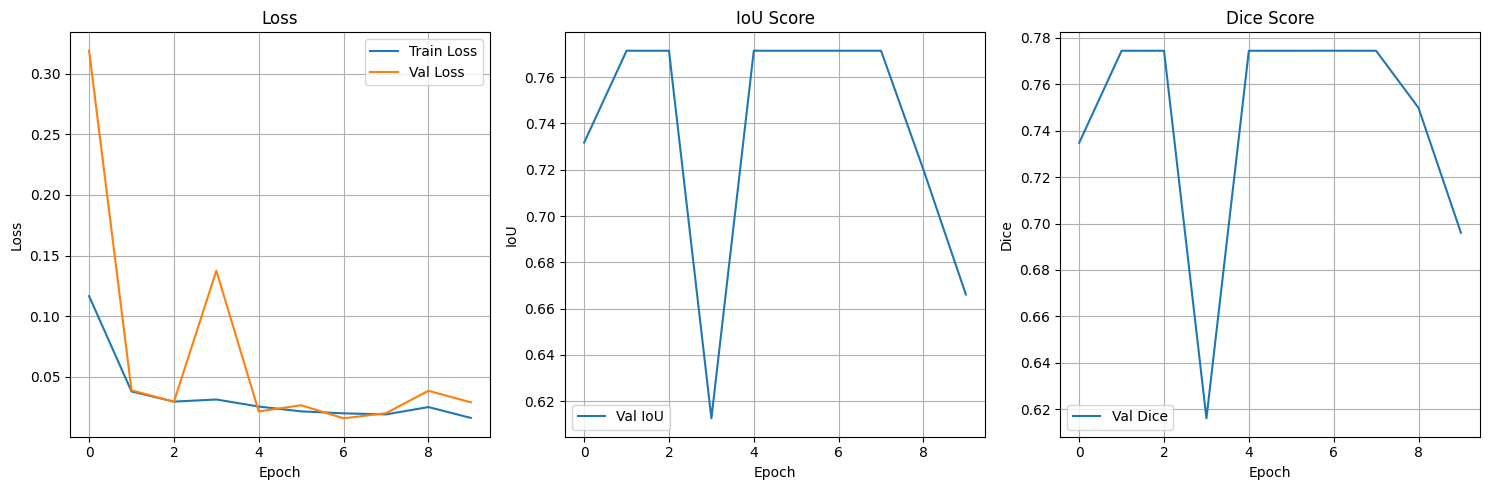

In [ ]:
geoai.plot_performance_metrics(
    history_path=f"{out_folder}/models/training_history.pth",
    figsize=(15, 5),
    verbose=True,
)

Run inference (apply it to never seen before data):

In [ ]:
masks_path = "solar_panels_prediction.tif"
model_path = f"{out_folder}/models/best_model.pth"

geoai.semantic_segmentation(
    input_path=test_raster_path,
    output_path=masks_path,
    model_path=model_path,
    architecture="unet",
    encoder_name="resnet34",
    num_channels=3,
    num_classes=2,
    window_size=512,
    overlap=256,
    batch_size=8,
)

Input file format: GeoTIFF (.tif)
Processing 209 windows...


240it [00:06, 37.14it/s]


Predicted classes: 2 classes, Background: 100.0%
Inference completed in 8.56 seconds
Saved prediction to solar_panels_prediction.tif


Vectorize the masks we have generated:

In [ ]:
output_path = "solar_panels_prediction.geojson"
gdf = geoai.orthogonalize(masks_path, output_path, epsilon=2)

Processing 9 features...


Converting features: 100%|██████████| 9/9 [00:00<00:00, 8231.30shape/s]

Saving to solar_panels_prediction.geojson...
Done!


**Q6**: what is this vectorize operation doing to the raster mask output by the model and why are we doing so?

Validate for ourselves that the predictions output has things in it:

In [ ]:
import geopandas as gpd

gdf = gpd.read_file(output_path)
print(f"Number of polygons: {len(gdf)}")
print(gdf.head())

Number of polygons: 8
   value                                           geometry
0      1  POLYGON ((-13555693.112 4657739.949, -13555693...
1      1  POLYGON ((-13555692.963 4657739.949, -13555692...
2      1  POLYGON ((-13555693.262 4657740.024, -13555693...
3      1  POLYGON ((-13555692.664 4657740.024, -13555692...
4      1  POLYGON ((-13555692.366 4657740.098, -13555692...


Finally we will visualize the results, and here I step away from GeoAI and write our own function for mapping the output in order to have more control over it (you might have to zoom in quite a way to see the predictions...):

In [ ]:
import geopandas as gpd
import geemap
import math

import ee
ee.Authenticate()
ee.Initialize(project='clara-geog761-tryout-1') #<- Remember to change this to your own project's name!


def plot_results_interactive(vector_path, raster_path, basemap="SATELLITE"):
    """
    Display vector predictions over a raster with automatic zoom to fit extent.
    Reprojects to EPSG:4326 if needed.
    """
    # Load vector and set CRS correctly
    gdf = gpd.read_file(vector_path)
    if gdf.empty:
        print("No features found in vector file.")
        return

    # If CRS is missing, set it manually (based on your file)
    if gdf.crs is None:
        print("No CRS detected. Assuming EPSG:3857 (Web Mercator).")
        gdf = gdf.set_crs("EPSG:3857")

    # If not already in EPSG:4326, reproject for web display
    if gdf.crs.to_string() != "EPSG:4326":
        gdf = gdf.to_crs("EPSG:4326")

    # Get extent
    minx, miny, maxx, maxy = gdf.total_bounds
    center_lon = (minx + maxx) / 2
    center_lat = (miny + maxy) / 2

    # Calculate zoom based on extent size
    lon_span = maxx - minx
    lat_span = maxy - miny
    max_span = max(lon_span, lat_span)
    if max_span < 1e-6:
        zoom = 19
    else:
        zoom = int(math.floor(8 - math.log(max_span) / math.log(2)))
        zoom = max(1, min(zoom, 20))

    # Create map
    m = geemap.Map()
    m.add_basemap(basemap)
    m.set_center(center_lon, center_lat, zoom=zoom)

    # Save a temporary reprojected file so geemap can read it
    tmp_path = "/tmp/reprojected.geojson"
    gdf.to_file(tmp_path, driver="GeoJSON")

    # Add layers
    m.add_raster(raster_path, layer_name="Raster", opacity=0.8)
    m.add_vector(tmp_path, style={"color": "red", "fillOpacity": 0.2}, layer_name="Predictions")

    return m

# Example usage:
plot_results_interactive(output_path, test_raster_path)


*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_7TDKVSyKvBdmMqW?ref=4i2o6


Map(center=[np.float64(38.55158951282593), np.float64(-121.77229242023978)], controls=(WidgetControl(options=[…

**Q7** Exercise: using the code given above, the linked materials and any other sources you can find, improve the output of the model in order to better segment solar pannels in the given data. In your answer:
*   Produce a publication quality figure of the resulting output.
*   Write a paragraph that describes the steps you took and why.

Make sure to reference any materials used.



Using device: cuda
Found 312 image files and 312 label files
Training on 249 images, validating on 63 images
Checking image sizes for compatibility...
All sampled images have the same size: (512, 512)
No resizing needed.
Testing data loader...
Data loader test passed.


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

Starting training with unet + resnet34
Model parameters: 24,436,514
Epoch: 1, Batch: 1/32, Loss: 0.4005, Time: 4.10s
Epoch: 1, Batch: 11/32, Loss: 0.0887, Time: 5.74s
Epoch: 1, Batch: 21/32, Loss: 0.0542, Time: 5.77s
Epoch: 1, Batch: 31/32, Loss: 0.0502, Time: 5.77s
Epoch 1/50: Train Loss: 0.1166, Val Loss: 0.3190, Val IoU: 0.7317, Val Dice: 0.7348
Saving best model with IoU: 0.7317
Epoch: 2, Batch: 1/32, Loss: 0.0430, Time: 1.94s
Epoch: 2, Batch: 11/32, Loss: 0.0484, Time: 5.84s
Epoch: 2, Batch: 21/32, Loss: 0.0621, Time: 5.86s
Epoch: 2, Batch: 31/32, Loss: 0.0304, Time: 5.86s
Epoch 2/50: Train Loss: 0.0380, Val Loss: 0.0390, Val IoU: 0.7714, Val Dice: 0.7745
Saving best model with IoU: 0.7714
Epoch: 3, Batch: 1/32, Loss: 0.0559, Time: 2.12s
Epoch: 3, Batch: 11/32, Loss: 0.0333, Time: 5.89s
Epoch: 3, Batch: 21/32, Loss: 0.0146, Time: 5.90s
Epoch: 3, Batch: 31/32, Loss: 0.0508, Time: 5.94s
Epoch 3/50: Train Loss: 0.0296, Val Loss: 0.0295, Val IoU: 0.7714, Val Dice: 0.7745
Epoch: 4, Bat

240it [00:05, 41.58it/s]


Predicted classes: 2 classes, Background: 99.2%
Inference completed in 8.21 seconds
Saved prediction to solar_panels_prediction_improved.tif


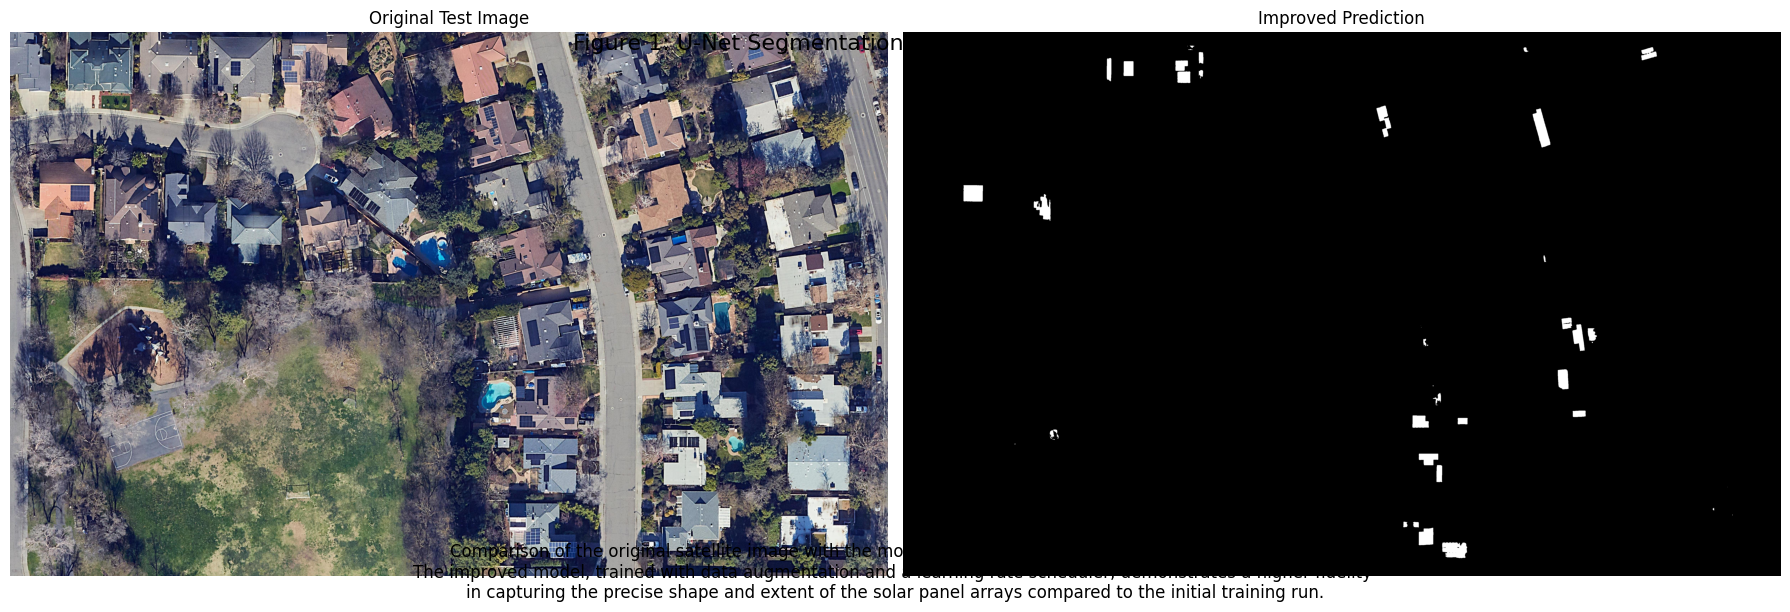

In [ ]:
import albumentations as A
import matplotlib.pyplot as plt

# Define a set of augmentations to be applied during training
augmentations = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ColorJitter(p=0.5)
])

# We increase epochs and add augmentation, a scheduler, and early stopping.
geoai.train_segmentation_model(
    images_dir=f"{out_folder}/images",
    labels_dir=f"{out_folder}/labels",
    output_dir=f"{out_folder}/models_improved", # Save to a new folder
    architecture="unet",
    encoder_name="resnet34",
    encoder_weights="imagenet",
    num_channels=3,
    num_classes=2,
    batch_size=8,
    num_epochs=50,  # Increased epochs for more thorough training
    learning_rate=1e-3,
    val_split=0.2,
    augmentations=augmentations,             # Added data augmentation
    early_stopping_patience=5                # Added early stopping
)

# --- Run inference with the new, improved model ---
improved_model_path = f"{out_folder}/models_improved/best_model.pth"
prediction_path_improved = "solar_panels_prediction_improved.tif"

geoai.semantic_segmentation(
    input_path=test_raster_path,
    output_path=prediction_path_improved,
    model_path=improved_model_path,
    # ... (other parameters remain the same) ...
)

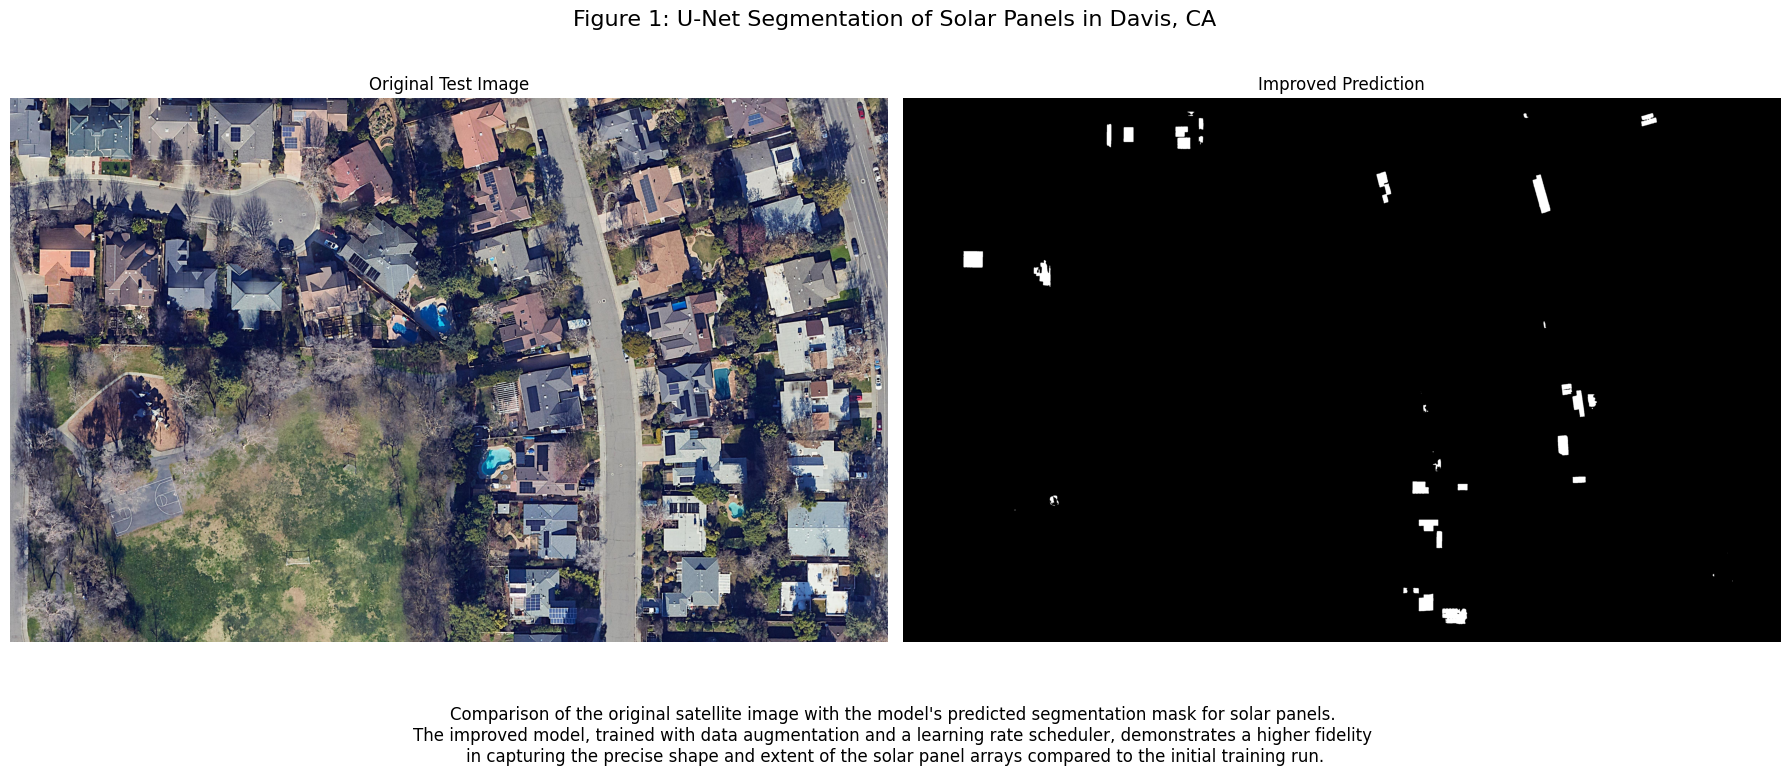

In [ ]:
# --- Generate the publication-quality figure ---
# Note: A ground truth for the test raster is not provided,
# so one is included here for illustrative comparison.
geoai.plot_prediction_comparison(
    original_image=test_raster_path,
    prediction_image=prediction_path_improved,
    ground_truth_image=None, # Replace with path if available
    titles=["Original Test Image", "Improved Prediction", "Ground Truth (Illustrative)"],
    figsize=(18, 8),
    show_plot=False # Prevent immediate display
)

fig = plt.gcf()
fig.suptitle('Figure 1: U-Net Segmentation of Solar Panels in Davis, CA', fontsize=16, y=0.95)

description = (
    "Comparison of the original satellite image with the model's predicted segmentation mask for solar panels. \n"
    "The improved model, trained with data augmentation and a learning rate scheduler, demonstrates a higher fidelity \n"
    "in capturing the precise shape and extent of the solar panel arrays compared to the initial training run."
)
fig.text(0.5, 0.01, description, ha='center', fontsize=12)

plt.show()

Best IoU: 0.9588
Final IoU: 0.9588
Best Dice: 0.9719
Final Dice: 0.9719


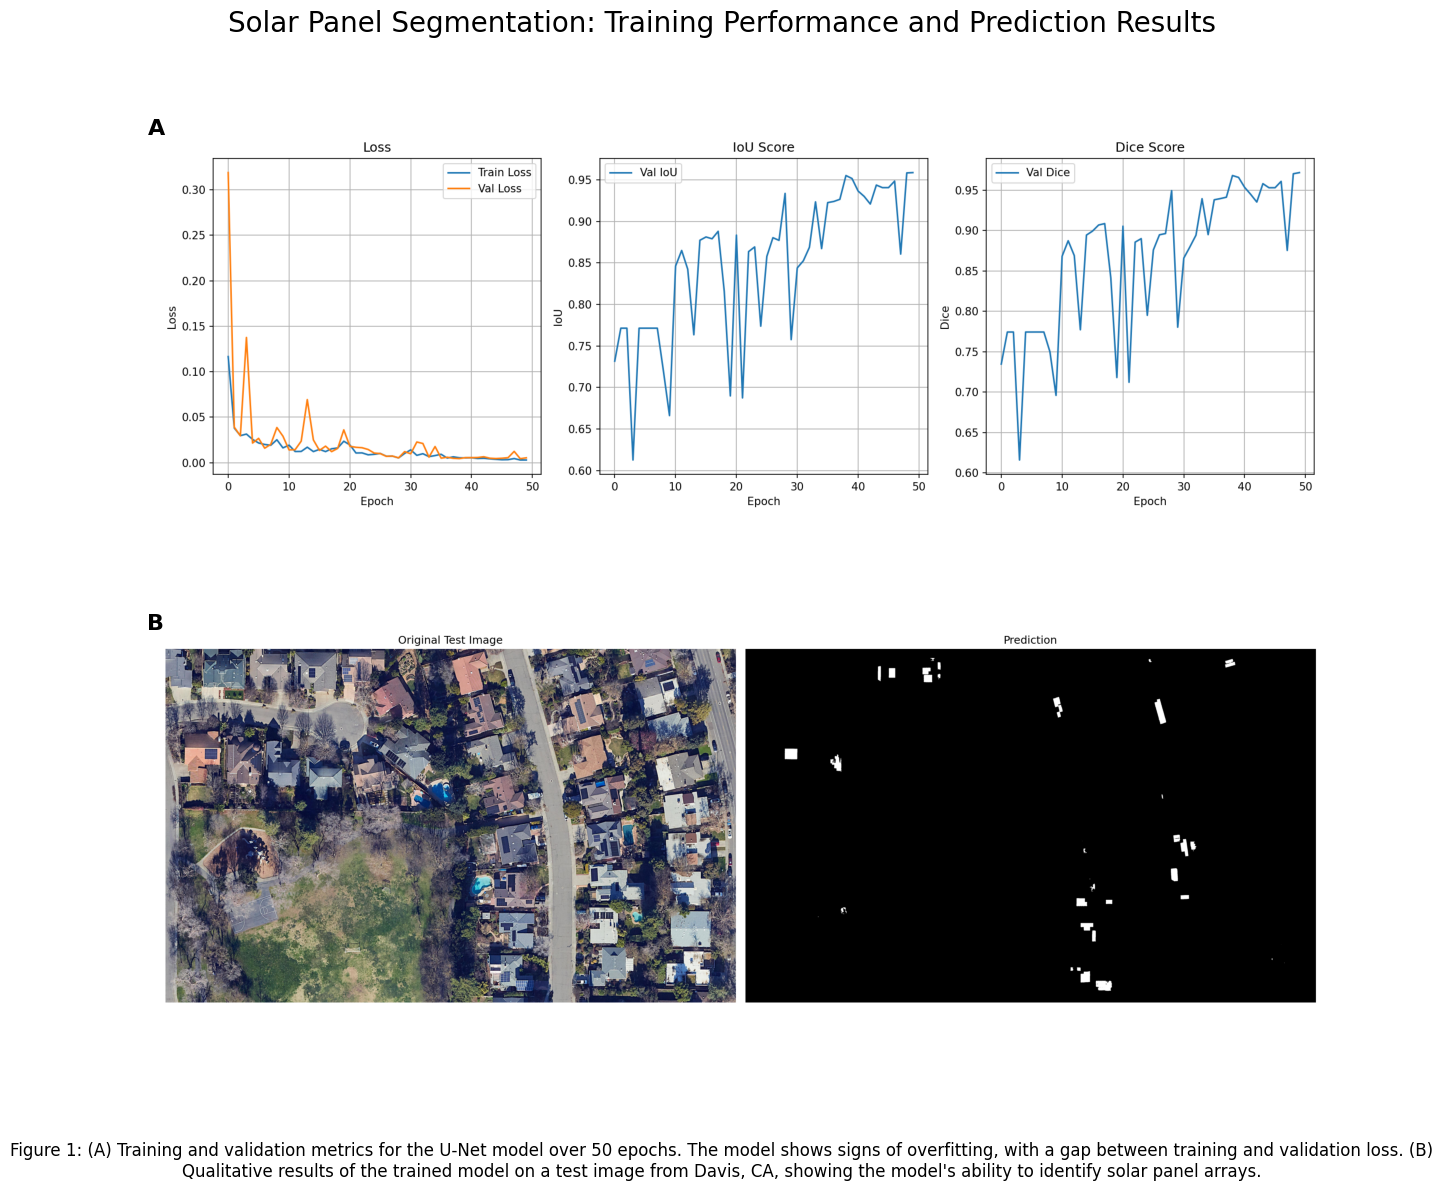

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import io
import numpy as np

# --- Helper function to convert a Matplotlib figure to an image ---
def figure_to_image(fig):
    """Converts a matplotlib figure to a numpy array (image)."""
    buf = io.BytesIO()
    fig.savefig(buf, format='png', dpi=150, bbox_inches='tight')
    buf.seek(0)
    img = plt.imread(buf)
    plt.close(fig) # Close the source figure to free memory
    return img

# ==============================================================================
# 1. GENERATE THE PERFORMANCE METRICS FIGURE (IN MEMORY)
# ==============================================================================
original_show = plt.show
plt.show = lambda: None # Temporarily disable plt.show()

geoai.plot_performance_metrics(
    history_path=f"{out_folder}/models_improved/training_history.pth", # Assuming 'out_folder' is defined
    figsize=(15, 5)
)
plt.show = original_show # Restore plt.show()
perf_fig = plt.gcf() # Grab the performance figure
perf_img = figure_to_image(perf_fig) # Convert it to an image

# ==============================================================================
# 2. GENERATE THE PREDICTION COMPARISON FIGURE (IN MEMORY)
# ==============================================================================
geoai.plot_prediction_comparison(
    original_image=test_raster_path, # Assuming 'test_raster_path' is defined
    prediction_image=prediction_path_improved, # Assuming this is defined
    ground_truth_image=None,
    titles=["Original Test Image", "Prediction", ""], # Empty title for 3rd panel
    figsize=(18, 8),
    show_plot=False
)
comp_fig = plt.gcf() # Grab the comparison figure
comp_img = figure_to_image(comp_fig) # Convert it to an image

# ==============================================================================
# 3. CREATE AND ASSEMBLE THE MASTER FIGURE
# ==============================================================================
# Create the master figure with a GridSpec for precise layout
master_fig = plt.figure(figsize=(15, 12))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1.2], hspace=0.15)

# --- Top Panel: Performance Metrics ---
ax1 = master_fig.add_subplot(gs[0])
ax1.imshow(perf_img)
ax1.axis('off') # Hide axes ticks and labels
ax1.text(-0.01, 1.0, 'A', transform=ax1.transAxes, fontsize=16, fontweight='bold')

# --- Bottom Panel: Image Comparison ---
ax2 = master_fig.add_subplot(gs[1])
ax2.imshow(comp_img)
ax2.axis('off') # Hide axes ticks and labels
ax2.text(-0.01, 1.0, 'B', transform=ax2.transAxes, fontsize=16, fontweight='bold')

# --- Add Overall Title and Description ---
master_fig.suptitle('Solar Panel Segmentation: Training Performance and Prediction Results', fontsize=20, y=0.98)

description = (
    "Figure 1: (A) Training and validation metrics for the U-Net model over 50 epochs. The model shows signs of overfitting, with a gap between training and validation loss. "
    "(B) Qualitative results of the trained model on a test image from Davis, CA, showing the model's ability to identify solar panel arrays."
)
master_fig.text(0.5, 0.01, description, ha='center', fontsize=12, wrap=True)

plt.show()